In [198]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Load Raw Data

In [199]:
folder_data = 'gemini/data/'
fn_data = 'tmb_mskcc_2018_clinical_data.tsv'
fp_data = os.path.join(folder_data, fn_data)

In [200]:
raw_data_df = pd.read_csv(fp_data, sep='\t', index_col=1)
print('Number of records:', raw_data_df.shape[0])
raw_data_df.head(4)

Number of records: 1661


,Study ID,Sample ID,Age at Which Sequencing was Reported (Days),Age Group at Diagnosis in Years,Cancer Type,Cancer Type Detailed,Drug Type,Gene Panel,Institute Source,Metastatic Site,...,Overall Survival Status,Primary Tumor Site,Sample Class,Number of Samples Per Patient,Sample coverage,Sample Type,Sex,Somatic Status,TMB Score,Tumor Purity
Patient ID,,,,,,,,,,,,,,,,,,,,,
P-0000057,tmb_mskcc_2018,P-0000057-T01-IM3,41.0,31-50,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,1:DECEASED,Breast,Tumor,1,835,Primary,Female,Matched,5.580000,25
P-0000062,tmb_mskcc_2018,P-0000062-T01-IM3,80.0,>71,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,1:DECEASED,Esophagus,Tumor,1,1176,Primary,Male,Matched,6.691462,30
P-0000063,tmb_mskcc_2018,P-0000063-T01-IM3,62.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,0:LIVING,Bladder,Tumor,1,900,Primary,Male,Matched,16.728656,70
P-0000071,tmb_mskcc_2018,P-0000071-T01-IM3,66.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,0:LIVING,Bladder,Tumor,1,795,Primary,Male,Matched,11.152437,30


## Constructure the time series dataframe and check matrix rank

In [201]:
def construct_ts_matrix(data_df, unit_defined_by=None, filter_by_column=None):
    """Returns a time series matrix for units.
    
    Args:
      data_df: The input dataframe.
      unit_defined_by: A column whose values will be used to group the rows of data_df to form units.
        If None, each row will be one unit.
      filter_by_column: A dict where the keys are column names and values are column values. If given,
        only rows with the matched column values are kept.
    """
    if filter_by_column:
      to_keep = None  
      for k,v in filter_by_column.items():
        if to_keep is None:
          to_keep = (data_df[k] == v)
        else:
          to_keep = (filter_flags & (data_df[k] == v))
      data_df = data_df[to_keep]
    
    # Next, besides survival data, we only keep the column used to define units.
    data_df = data_df[[unit_defined_by, KEY_SURVIVAL_MONTH]]
    units = sorted(list(set(data_df[unit_defined_by])))
    max_survival_mo = int(np.floor(np.max(data_df[KEY_SURVIVAL_MONTH])))
    ts_matrix = np.zeros((len(units), max_survival_mo), dtype=np.float)
     
    for i, u in enumerate(units):
      # The survival months for all patients in this unit.
      survival_mos = data_df[data_df[unit_defined_by]==u][KEY_SURVIVAL_MONTH].to_numpy()   
      n_patients_in_unit = len(survival_mos)
      # Now we want to know how many of them survived for 1 month, 2 months, ....
      survival_counts = [np.sum(survival_mos >= i) for i in range(1, max_survival_mo + 1)]
      ts_matrix[i,:] = np.array(survival_counts) / n_patients_in_unit
    return ts_matrix, units

def plot_spectrum(ts_matrix):
  (U, s, Vh) = np.linalg.svd((ts_matrix) - np.mean(ts_matrix))
  s2 = np.power(s, 2)
  spectrum = np.cumsum(s2)/np.sum(s2)

  plt.plot(spectrum)
  plt.grid()
  plt.title("Cumulative energy")
  plt.figure()
  plt.plot(s2)
  plt.grid()
  plt.xlabel("Ordered Singular Values") 
  plt.ylabel("Energy")
  plt.title("Singular Value Spectrum")


def analyze_ts_matrix_rank(drug_type):
  ts_matrix, units = construct_ts_matrix(
      data_df,
      unit_defined_by=KEY_CANCER_TYPE,
      filter_by_column={KEY_DRUG_TYPE:drug_type})
  print(survival_df)
  ts_df = pd.DataFrame(data=ts_matrix, index=units, columns=range(1, ts_matrix.shape[1]+1))
  print(ts_df)
  plot_spectrum(ts_df)

In [202]:
KEY_SURVIVAL_MONTH = 'Overall Survival (Months)'
KEY_CANCER_TYPE = 'Cancer Type'
KEY_DRUG_TYPE = 'Drug Type'
KEY_PATIENT_ID = 'Patient ID'

data_df = raw_data_df[[KEY_CANCER_TYPE, KEY_DRUG_TYPE, KEY_SURVIVAL_MONTH]]
data_df.head(4)

,Cancer Type,Drug Type,Overall Survival (Months)
Patient ID,,,
P-0000057,Breast Cancer,PD-1/PDL-1,0
P-0000062,Esophagogastric Cancer,PD-1/PDL-1,1
P-0000063,Bladder Cancer,PD-1/PDL-1,42
P-0000071,Bladder Cancer,PD-1/PDL-1,43


                           Overall Survival (Months)
Bladder Cancer                               10.8698
Breast Cancer                                    7.4
Cancer of Unknown Primary                    6.67105
Colorectal Cancer                            11.5859
Esophagogastric Cancer                       7.54839
Glioma                                       11.6842
Head and Neck Cancer                         9.87786
Melanoma                                        16.1
Non-Small Cell Lung Cancer                   11.6383
Renal Cell Carcinoma                         22.3689
Skin Cancer, Non-Melanoma                          2
                                  1         2         3         4         5   \
Bladder Cancer              0.984375  0.927083  0.869792  0.770833  0.703125   
Breast Cancer               0.950000  0.900000  0.800000  0.600000  0.400000   
Cancer of Unknown Primary   0.973684  0.815789  0.710526  0.605263  0.526316   
Colorectal Cancer           1.000000  0.9797

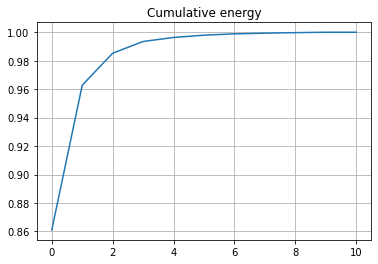

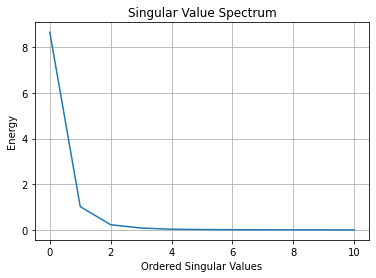

In [203]:
analyze_ts_matrix_rank('PD-1/PDL-1')

                           Overall Survival (Months)
Bladder Cancer                               10.8698
Breast Cancer                                    7.4
Cancer of Unknown Primary                    6.67105
Colorectal Cancer                            11.5859
Esophagogastric Cancer                       7.54839
Glioma                                       11.6842
Head and Neck Cancer                         9.87786
Melanoma                                        16.1
Non-Small Cell Lung Cancer                   11.6383
Renal Cell Carcinoma                         22.3689
Skin Cancer, Non-Melanoma                          2
                            1         2         3         4         5     6   \
Breast Cancer              1.0  0.850000  0.800000  0.700000  0.650000  0.50   
Cancer of Unknown Primary  1.0  1.000000  0.000000  0.000000  0.000000  0.00   
Colorectal Cancer          1.0  1.000000  1.000000  1.000000  0.000000  0.00   
Esophagogastric Cancer     1.0  0.500000  0.

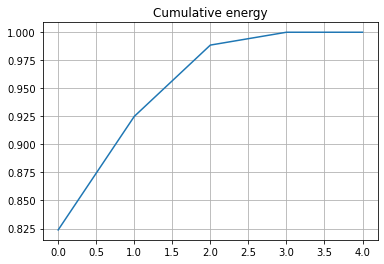

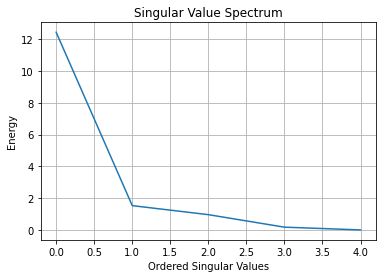

In [204]:
analyze_ts_matrix_rank('CTLA4')

                           Overall Survival (Months)
Bladder Cancer                               10.8698
Breast Cancer                                    7.4
Cancer of Unknown Primary                    6.67105
Colorectal Cancer                            11.5859
Esophagogastric Cancer                       7.54839
Glioma                                       11.6842
Head and Neck Cancer                         9.87786
Melanoma                                        16.1
Non-Small Cell Lung Cancer                   11.6383
Renal Cell Carcinoma                         22.3689
Skin Cancer, Non-Melanoma                          2
                                  1         2         3         4         5   \
Bladder Cancer              1.000000  1.000000  0.956522  0.913043  0.869565   
Breast Cancer               1.000000  1.000000  0.750000  0.750000  0.750000   
Cancer of Unknown Primary   1.000000  0.636364  0.545455  0.454545  0.363636   
Colorectal Cancer           1.000000  0.9000

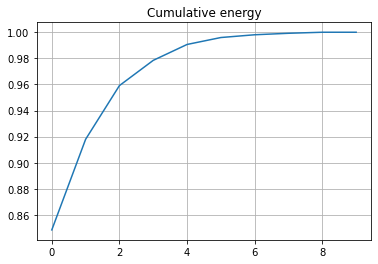

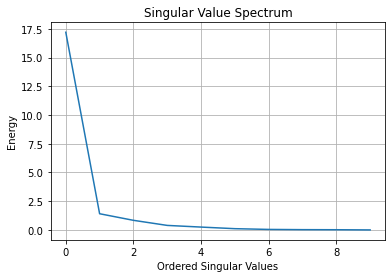

In [205]:
analyze_ts_matrix_rank('Combo')